In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils._raised_cosine_basis import makeRaisedCosBasis
from utils.load_matlab import load_mat_v73, flatten_cell
import torch.nn.functional as F
import h5py
import math

In [2]:
# from utils.stim_utils import generate_1_f_noise, plot_stim
# beta= 0
# mean_intensity = 0.15
# desired_contrast = 0.3
# stim_duration = 5
# trials = 10
# frame_rate = 60
# dt_stim = 1/frame_rate
# frame_dwell = 1
# tau = 10

# all_noise = []
# all_contrast = []
# for trial in range(trials):
#     noise, contrast = generate_1_f_noise(
#         beta, frame_rate * stim_duration, frame_rate,
#         frame_dwell, mean_intensity, desired_contrast,
#         noise_seed=trial)
#     all_noise.append(noise)
#     all_contrast.append(contrast)

# noise_t = np.concatenate(all_noise)
# contrast_t = np.concatenate(all_contrast)
# stim = np.array(all_contrast)

# plot_stim(noise_t=noise_t, contrast_mat=stim,
#           beta=beta,
#           mean_intensity=mean_intensity,
#           desired_contrast=desired_contrast,
#           tau=10, frame_rate=60, figsize=(16,7))

In [3]:
# load stimulus and spike times from the matlab file
filename = "Data/example.mat"
with h5py.File(filename, "r") as f:
    # Get the data
    stimulus  = np.array(list(f["X"]))[0]
    spkVector = np.array(list(f["Y"]))[0]
    CBEM_True = np.array(list(f["CBEM_true"]))
spkTimes_bins = np.where(spkVector > 0)[0]
spkTimes_bins = torch.as_tensor(spkTimes_bins, dtype=torch.float32)

In [4]:
cbem = load_mat_v73("Data/example.mat", "CBEM_true")

In [5]:
dt      = float(cbem["dt"])
E_l     = float(cbem["E_l"])
initV   = float(cbem["initV"])
g_l     = float(cbem["g_l"])
log_g_l = float(cbem["log_g_l"])

E_s     = np.array(cbem["E_s"]).squeeze()
g_s_bar = np.array(cbem["g_s_bar"]).squeeze()

stimBasisVectors = np.array(cbem["stimBasisVectors"])
spkHistBasisVectors = np.array(cbem["spkHistBasisVectors"])

k_s_list = [np.array(x).squeeze() for x in flatten_cell(cbem["k_s"])]
print(len(k_s_list), [ks.shape for ks in k_s_list])

3 [(11,), (11,), ()]


In [6]:
k_s_list

[array([ 3.34660856, -0.05497898, -4.5200135 ,  1.12255473,  2.58127387,
         0.98791104, -1.4975961 , -0.94409404,  1.04839801, -0.2073798 ,
        34.12936117]),
 array([-13.05721393, -16.91422897,  19.46093134,   9.35085393,
         -4.44276807,  -8.84959567,  -2.93733151,   3.79575549,
          3.31449375,   3.33806961,  47.5604315 ]),
 array(5.16478597)]

In [7]:

dt = float(cbem["dt"])  # seconds (in your CBEM_true)
stimBasisVectors = np.array(cbem["stimBasisVectors"]).T   # [L, P]
stimNumBasisVectors = int(np.squeeze(cbem["stimNumBasisVectors"]))

# k_s{1} as a 1D array
# (if you used the flatten_cell helper from earlier)
k_e = np.array(k_s_list[0]).squeeze()
k_i = np.array(k_s_list[1]).squeeze()

print(k_e.shape, k_i.shape)
# MATLAB: k_s{1}(1:stimNumBasisVectors)
k_e = k_e[:stimNumBasisVectors]   # Python is 0-indexed
k_i = k_i[:stimNumBasisVectors]
L = stimBasisVectors.shape[0]

(11,) (11,)


In [8]:
nLinearRFs = 10 #;     %number of stimulus basis functions
numShortSHFilts = 5#; %each is 0.4ms long - used for refractory period
nSHfilters = 7+numShortSHFilts#;%7+

nInh = 1#;
nExc = 1#

dt = 1e-4

RFstart = 2e-3 #;%0?
RFend   = 150e-3#;%150e-3 or 180e-3;
b = 0.02
t, B_orth, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
B_orth.shape

(2478, 10)

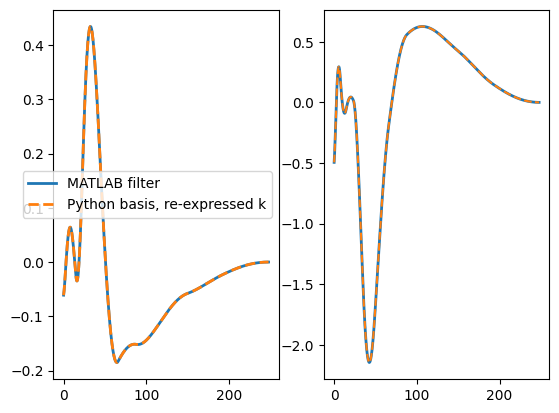

In [9]:

f_e_mat = stimBasisVectors @ k_e
f_i_mat = stimBasisVectors @ k_i

k_e_py = B_orth.T @ f_e_mat
k_i_py = B_orth.T @ f_i_mat
f_e_py = B_orth @ k_e_py
f_i_py = B_orth @ k_i_py

t_ms = np.arange(1, L+1) * dt * 1e3
fig, axes = plt.subplots(1, 2)


axes[0].plot(t_ms, f_e_mat, linewidth=2, label="MATLAB filter")
axes[0].plot(t_ms, f_e_py, linewidth=2, linestyle="--", label="Python basis, re-expressed k")
axes[0].legend()

axes[1].plot(t_ms, f_i_mat,  linewidth=2, label="MATLAB filter")
axes[1].plot(t_ms, f_i_py, linestyle="--", label="Python basis, re-expressed k")
# axes[0].legend()
plt.show()

In [10]:
condType = np.array(cbem["condType"]).squeeze().astype(int)   # MATLAB uses 1,2,3,...
g_s_bar  = np.array(cbem["g_s_bar"]).squeeze().astype(np.float32)
E_s      = np.array(cbem["E_s"]).squeeze().astype(np.float32)

# In MATLAB: condType==2 means stimulus-driven conductance
stim_cond_inds = np.where(condType == 2)[0]
print("stim cond inds:", stim_cond_inds, "nConds:", len(condType))

stim cond inds: [0 1] nConds: 3


# Our sim

In [11]:
nLinearRFs = 10 #;     %number of stimulus basis functions
numShortSHFilts = 5#; %each is 0.4ms long - used for refractory period
nSHfilters = 7+numShortSHFilts#;%7+

nInh = 1#;
nExc = 1#

dt = 1e-4 
dt_ms = dt*1000
# dt_ms =  0.1
RFstart = 2e-3 #2ms in s
RFend   = 150e-3#%150ms in s
b = 0.02
t, basis_v_o, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
stimulus_t = torch.as_tensor(stimulus, dtype=torch.float32)
basis_v_ot = torch.as_tensor(basis_v_o, dtype=torch.float32)

In [ ]:
import torch
import torch.nn.functional as F
import math

def convolveStimulusWithBasis_torch(stimulus: torch.Tensor, basis: torch.Tensor, add_ones: bool = True):
    if stimulus.ndim == 1:
        stimulus = stimulus[:, None]  # [T, Npix]
    T, Npix = stimulus.shape
    L, P = basis.shape                                  # basis: [Lags, #basis vectors]

    x = stimulus.transpose(0, 1).unsqueeze(1)           # [Npix, 1, T]
    w = basis.transpose(0, 1).flip(1).unsqueeze(1)      # [P, 1, L]

    # y = F.conv1d(F.pad(x, (L, 0)), w)                   # [Npix, P, T+1]
    # y = y[..., :T]                                      # -> [Npix, P, T]
    y = F.conv1d(F.pad(x, (L-1, 0)), w)   # -> length T

    X = y.permute(2, 0, 1).reshape(T, Npix * P)         # [T, Npix*P]

    if add_ones:
        X = torch.cat([X, torch.ones(T, 1, device=X.device, dtype=X.dtype)], dim=1)
    return X

# def log_one_plus_exp_x(x, gbar, clamp=80.0):
    
#     return gbar * F.softplus(x, threshold=clamp)   # gbar * softplus(x) #defualt is 20 so may need to change it!

def logOnePlusExpX_torch(x, maxG):
    """
    Match MATLAB logOnePlusExpX.m

    x:    [T, nConds] or [T]
    maxG: scalar or [nConds] broadcastable to x
    """
    # ensure tensor
    x = torch.as_tensor(x)
    maxG = torch.as_tensor(maxG, device=x.device, dtype=x.dtype)

    # broadcast maxG to x shape if needed
    while maxG.ndim < x.ndim:
        maxG = maxG.unsqueeze(0)

    f = x.clone()

    lessT = x <= -30.0
    greaterT = x >= maxG
    toFit = (~lessT) & (~greaterT)

    # log(1+exp(x)) safely
    f[toFit] = F.softplus(x[toFit])          # softplus = log(1+exp)
    f[lessT] = 1e-15
    # f[greaterT] already equals x

    return f

def get_voltage_exp_recurrence(gs, E_s, g_l, E_l, V0, dt_s, eps=1e-12):
    """
    Single-compartment exponential (exact) update for piecewise-constant conductances per bin.

    gs:   [T, C] conductances (>=0)
    E_s:  [C] reversal potentials
    g_l:  scalar leak conductance
    E_l:  scalar leak reversal
    V0:   scalar initial voltage. In paper they initialize as E_l
    dt_s: bin size in seconds

    Returns:
      V: [T]
    """
    # totals
    g_tot = g_l + gs.sum(dim=1)                        # [T]
    I_tot = E_l * g_l + gs @ E_s                       # [T]   (sum g*E)

    # V_inf(t) = I_tot / g_tot
    V_inf = I_tot / (g_tot + eps)                      # [T]

    # a(t) = exp(-dt*g_tot)
    a = torch.exp(-dt_s * g_tot)                       # [T] in (0,1] if g_tot>=0

    V = torch.empty_like(g_tot)
    v_prev = torch.as_tensor(V0, device=gs.device, dtype=gs.dtype)
    ## THIS IS GONNA BE SLOWW
    for t in range(gs.shape[0]):
        v_prev = a[t] * v_prev + (1.0 - a[t]) * V_inf[t]
        V[t] = v_prev
    return V

def get_voltage_matlab_form(gs, E_s, g_l, E_l, initVoltage, dt, EXP_MAX=500.0, eps=1e-12):
    # g_l = torch.exp(log_g_l)

    c = g_l + gs.sum(dim=1)                 # [T]
    b = g_l * E_l + gs @ E_s                # [T]
    bc = b / (c + eps)

    exc = torch.exp(torch.clamp(c * dt, max=EXP_MAX))  # <-- dt in seconds (same as CBEM.dt)
    I = bc * (exc - 1.0)

    I = I.clone()
    I[0] = I[0] + initVoltage               # <-- MATLAB injects initVoltage into I(1)

    V = torch.empty_like(I)
    V[0] = I[0] / exc[0]
    for t in range(1, I.shape[0]):
        V[t] = (I[t] + V[t-1]) / exc[t]
    return V

def firingRateNonlinearity(V_t, alpha, mu, beta):
    """ 
    Computes the firing rate nonlinearity on the given total voltage.
        The nonlinearity is alpha * softplus((V_tot - mu)/beta)
    From Mensi et al. 2011(From stochastic NL IF to GLMS)
    """
    return alpha * F.softplus((V_t - mu)/beta)
    

class CBEM_torch:
    def __init__(self, binsize_s, basis_conductance):
        """
        binsize_s: time bin in seconds (e.g. dt = 1e-4)
        basis_conductance: [L, P]
        """
        self.binsize_s = float(binsize_s)

        if basis_conductance.ndim == 1:
            basis_conductance = basis_conductance[:, None]
        assert basis_conductance.ndim == 2
        self.basis_conductance = basis_conductance  # [L, P]

        self.X_cond = None
        self.spkTimes_bins = None
        self.window = None

        # conductance nonlinearity gains (MATLAB g_s_bar)
        self.gbar_exc = 80.0
        self.gbar_inh = 80.0

        # LIF / membrane params (set defaults like your JAX class; adjust to match MATLAB)
        self.E_s = torch.tensor([0.0, -80.0])   # [exc, inh] reversal
        self.E_l = -60.0
        self.g_l = 200 ## Check this, we want a 4ms time constant!!
        # self.log
        self.V0  = self.E_l

        self._B_cond = None  # weights of basis functions [(P*Npix + 1), 2]
        
        self.alpha = 90
        self.beta  = 1.67
        self.mu    = -53

    @property
    def B_cond(self):
        return self._B_cond

    @B_cond.setter
    def B_cond(self, value):
        assert self._B_cond is not None, "B_cond not initialized; call setObservations first"
        assert value.shape == self._B_cond.shape, f"Expected {self._B_cond.shape}, got {value.shape}"
        self._B_cond = value

    def setObservations(self, stimulus, spkTimes_bins, window, add_ones=True):
        if not torch.is_tensor(stimulus):
            stimulus = torch.as_tensor(stimulus, dtype=torch.float32)
        if stimulus.ndim == 1:
            stimulus = stimulus[:, None]  # [T,Npix]

        self.N_pixels = math.prod(stimulus.shape[1:])
        X = convolveStimulusWithBasis_torch(stimulus, self.basis_conductance, add_ones=add_ones)

        window = torch.as_tensor(list(window), dtype=torch.long, device=X.device)
        self.window = window
        self.X_cond = X[window]

        spk = torch.as_tensor(spkTimes_bins, dtype=torch.long, device=X.device)
        mask = (spk >= window[0]) & (spk <= window[-1])
        self.spkTimes_bins = spk[mask] - window[0]

        # initialize parameters for this stimulus dimensionality
        P = self.basis_conductance.shape[1]
        self._B_cond = torch.zeros(P * self.N_pixels + 1, 2, device=X.device, dtype=X.dtype)

    # def getConductances(self, B_cond=None):
    #     if B_cond is None:
    #         B_cond = self._B_cond
    #     assert self.X_cond is not None, "Call setObservations first"

    #     x = self.X_cond @ B_cond  # [T,2]

    #     gbar = torch.tensor([self.gbar_exc, self.gbar_inh],
    #                         device=x.device, dtype=x.dtype)  # [2]
    #     return log_one_plus_exp_x(x, gbar)  # [T,2]
    
    def getConductances(self, B_cond=None):
        if B_cond is None:
            B_cond = self._B_cond
        x = self.X_cond @ B_cond  # [T, nConds]

        # MATLAB: g_s_fit(:,cc) = logOnePlusExpX(l_s_fit(:,cc), g_s_bar(cc))
        maxG = torch.tensor([self.gbar_exc, self.gbar_inh], device=x.device, dtype=x.dtype)
        return logOnePlusExpX_torch(x, maxG)

    def getVoltage(self, B_cond=None, method="exp"):
        """
        method:
          "exp"    -> V_t = a_t V_{t-1} + (1-a_t) Vinf_t   (recommended)
          "matlab" -> V_t = (I_t + V_{t-1}) / exc_t        (equivalent)
        """
        gs = self.getConductances(B_cond)  # [T,2]

        # make sure E_s is on correct device/dtype
        E_s = self.E_s.to(device=gs.device, dtype=gs.dtype)

        if method == "exp":
            return get_voltage_exp_recurrence(gs, E_s, self.g_l, self.E_l, self.V0, self.binsize_s)
        elif method == "matlab":
             return get_voltage_matlab_form(gs, E_s, self.g_l, self.E_l, self.V0, self.binsize_s)
        else:
            raise ValueError("method must be 'exp' or 'matlab'")
        
    def getSpikeRate(self, B_cond=None):
        if B_cond is None:
            B_cond = self._B_cond
        V_tot = self.getVoltage(B_cond)
        return firingRateNonlinearity(V_tot, self.alpha, self.mu, self.beta)
        


## Main API 

In [56]:
## CBEM object

##Convolve stim with basis and create design matrix
cbem = CBEM_torch(dt, basis_v_ot)
window = range(0,70000); # range of bins to use 
cbem.setObservations(stimulus_t, spkTimes_bins, window)


In [57]:

# After cbem.setObservations(...):
nFeat = cbem.X_cond.shape[1]  # should be 11

# Build B_cond for the two stimulus conductances
k0 = torch.tensor(k_s_list[0], dtype=cbem.X_cond.dtype)  # len 11
k1 = torch.tensor(k_s_list[1], dtype=cbem.X_cond.dtype)  # len 11
B_cond = torch.stack([k0, k1], dim=1)                    # [11, 2]

cbem.B_cond = B_cond

# Also set g_s_bar per cond (don’t hardcode 30/30 if you’re matching)
# cbem.g_s_bar = torch.tensor(g_s_bar[:2], dtype=cbem.X_cond.dtype)

gs = cbem.getConductances()  # [T_window, 2]

Vm = cbem.getVoltage()
Fr = cbem.getSpikeRate()

/tmp/ipykernel_49272/2329294861.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


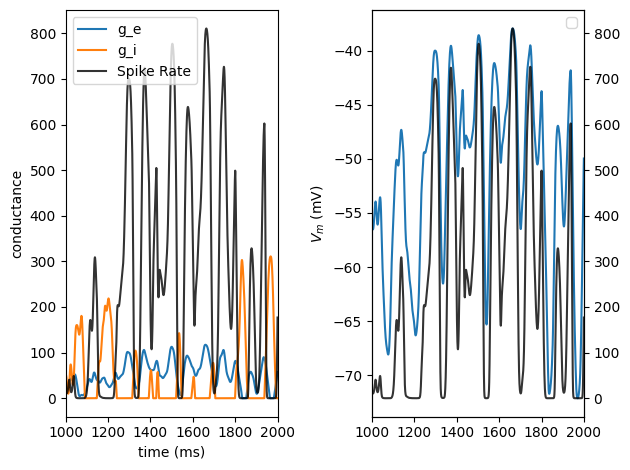

In [68]:
## General shape is okay but we are off but a scale factor and not including the leak conductance!!
pltLength_bins = 20000
t_ms = np.arange(pltLength_bins)*dt*1e3 
fig, axes = plt.subplots(1, 2)
axes[0].plot(t_ms, gs[0:pltLength_bins,:], label=["g_e", "g_i"])
axes[0].plot(t_ms, Fr[0:pltLength_bins], label='Spike Rate', c='k', alpha =0.8)
axes[0].set_xlabel('time (ms)')
axes[0].set_ylabel('conductance')

axes[1].plot(t_ms, Vm[:pltLength_bins])
axes[1].set_ylabel(r'$V_m \text{ (mV)}$')
rate_ax = axes[1].twinx()
rate_ax.plot(t_ms, Fr[0:pltLength_bins], label='Spike Rate', c='k', alpha =0.8)
for ax in axes:
    ax.set_xlim(1000,2000)
    ax.legend()
fig.tight_layout()
plt.show()

## This is super similar to MATLAB's!!

TO DO:
- Check that voltage is okay --> **DONE**
- Implement leak conductance. Though I'm not sure any of it is a learnable param. 
- Ensure time constant is 4ms
- Once Vm works, check spike rate nonlinearity. 
- Then loglikelihood, fitting AND initialization!

In [ ]:


X_np = np.array(cbem.X_cond[:20000,:])   # or: jax.device_get(X_cond_jax)
plt.figure(figsize=(8,4))
plt.imshow(X_np, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title("Design matrix (Stim projected onto basis f)")
plt.xlabel("features")
plt.ylabel("time bin")
plt.show()


# x_e = X_cond @ k_e + bias_e

# g_e = logOnePlusExpX_torch(x_e, g_s_bar_e)

# same for g_i

# V = solve_voltage_implicit(g_e, g_i, dt, g_l, ...)

# sph = X_hspk @ h_spk

# lam = softrec_rate(V, sph, ...)

# loss = NLL(lam, y) + penalties/priors

In [ ]:
nLinearRFs = 10 #;     %number of stimulus basis functions
numShortSHFilts = 5#; %each is 0.4ms long - used for refractory period
nSHfilters = 7+numShortSHFilts#;%7+

nInh = 1#;
nExc = 1#

dt = 1e-4

RFstart = 2e-3 #;%0?
RFend   = 150e-3#;%150e-3 or 180e-3;
b = 0.02
t, B_orth, B_raw = makeRaisedCosBasis(nLinearRFs, dt, [RFstart, RFend], b, zflag=0)
stimulus_t = torch.as_tensor(stimulus, dtype=torch.float32)
B_orth_t   = torch.as_tensor(B_orth,   dtype=torch.float32)

X_cond = convolveStimulusWithBasis_torch(stimulus_t, B_orth_t)
# CBEM.stimNumBasisVectors = size(CBEM.stimBasisVectors,2);
stimNumBasisVectors = B_orth.shape[1]

plt.figure()
plt.plot(t, B_raw)
plt.xlabel("Lag (s)")
plt.ylabel("Basis value")
plt.title("Raised-cosine log-time basis (raw)")
plt.show()

plt.figure()
plt.plot(t, B_orth)
plt.xlabel("Lag (s)")
plt.ylabel("Basis value")
plt.title("Raised-cosine basis after orthonormalization (SVD)")
plt.show()